#  Simulated Daily Activity Dataset from Smartwatch Sensors

This synthetic dataset simulates daily motion signals collected from **1000 individuals** wearing a smartwatch over a **30-day** period.

###  How it was generated:
- Each individual is randomly assigned to one of **6 activity profiles**:
  - 0 = Sedentary
  - 1 = Normal walking
  - 2 = Brisk walking
  - 3 = Jogging
  - 4 = Irregular movement
  - 5 = Abnormal sensor behavior
- Each activity label has a **unique set of 3 underlying sine functions** representing its movement dynamics.
- Each person's daily signal is a **random weighted mix of their label's sine waves**, with added Gaussian noise to simulate real-world variability.


###  Purpose:
- Train a 1D-CNN to classify activity profiles using raw temporal data
- Ensure label consistency through shared signal structure across people

---

This dataset is well-suited for teaching CNNs on time-series signals with known label structure.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
#unzip file
file_path="/content/human+activity+recognition+using+smartphones.zip"


In [ ]:
# Set random seed
np.random.seed(42) #ensures enerated data is unifrom for  everyone

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
n_people = 1500
n_days = 30
timesteps_per_day = 128
n_labels = 6
n_latent_per_label = 3  # number of latent sine functions per class
total_samples = n_people * n_days

# Assign a label to each person uniformly
person_labels = np.random.choice(n_labels, size=n_people)
print("Label distribution (people):", dict(zip(*np.unique(person_labels, return_counts=True))))

# Time vector for a day
time = np.linspace(0, 2 * np.pi, timesteps_per_day)

# Generate latent signal templates per label
label_templates = {}
for label in range(n_labels):
    # e.g., 3 sine waves with slightly different frequencies
    label_templates[label] = np.array([np.sin((f + 1) * time + label) for f in range(n_latent_per_label)])

# Build data: shape (samples, timesteps)
X = []
y = []

for person_id in range(n_people):
    label = person_labels[person_id]
    template = label_templates[label]

    for _ in range(n_days):
        # Mix latent waves with random weights and small noise
        weights = np.random.randn(n_latent_per_label)
        signal = weights @ template + 0.1 * np.random.randn(timesteps_per_day)
        X.append(signal)
        y.append(label)

X = np.stack(X)  # shape: (500 × 30, 128)
y = np.array(y)  # shape: (500 × 30,)

print("Final shape of X:", X.shape)  # (15000, 128)
print("Final shape of y:", y.shape)
print("Class distribution:", dict(zip(*np.unique(y, return_counts=True))))


Label distribution (people): {np.int64(0): np.int64(266), np.int64(1): np.int64(242), np.int64(2): np.int64(243), np.int64(3): np.int64(248), np.int64(4): np.int64(253), np.int64(5): np.int64(248)}
Final shape of X: (45000, 128)
Final shape of y: (45000,)
Class distribution: {np.int64(0): np.int64(7980), np.int64(1): np.int64(7260), np.int64(2): np.int64(7290), np.int64(3): np.int64(7440), np.int64(4): np.int64(7590), np.int64(5): np.int64(7440)}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Visualize Raw Sensor Data
We visualize a few sensor channels to understand the structure and noise.

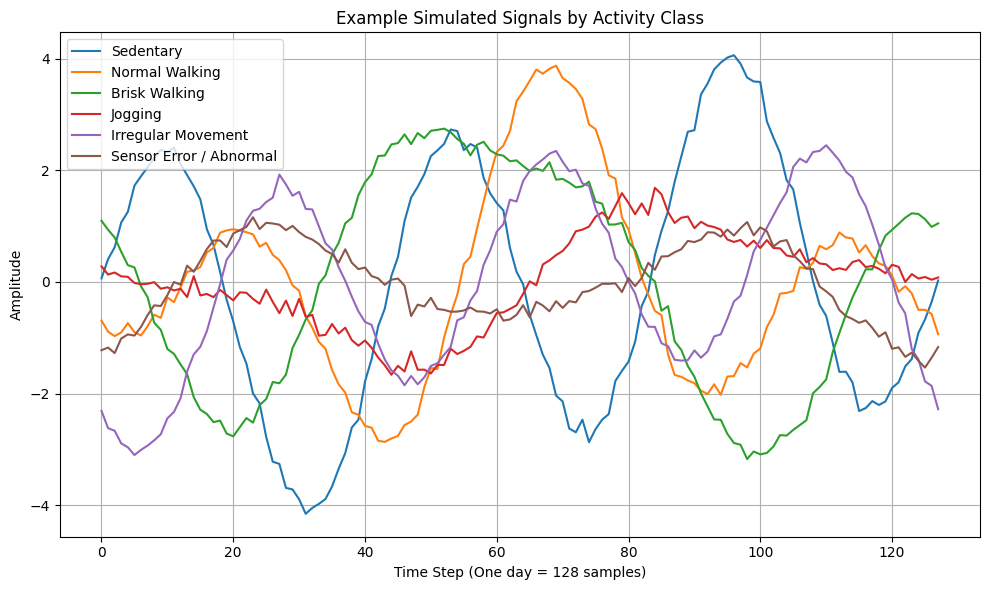

In [ ]:
# Define descriptive names for each activity label
activity_names = {
    0: "Sedentary",
    1: "Normal Walking",
    2: "Brisk Walking",
    3: "Jogging",
    4: "Irregular Movement",
    5: "Sensor Error / Abnormal"
}

# Create a figure with appropriate size
plt.figure(figsize=(10, 6
                    ))

# Loop through each label and plot one sample for each
for label in range(n_labels):
    # Find the first index where this label appears
    sample_idx = np.where(y == label)[0][0]

    # Extract the corresponding signal (a single 128-length time window)
    signal = X[sample_idx]

    # Plot the signal with a descriptive label
    plt.plot(signal, label=activity_names[label])

# Set plot title and axis labels
plt.title("Example Simulated Signals by Activity Class")
plt.xlabel("Time Step (One day = 128 samples)")
plt.ylabel("Amplitude")

# Display legend with activity names
plt.legend()

# Improve spacing and layout
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


# Prepare PyTorch Dataset and DataLoader

In [ ]:

# Define PyTorch dataset
class SignalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X[:, np.newaxis, :], dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_ds = SignalDataset(X_train, y_train)
test_ds = SignalDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)


# Define a simple 1D-CNN Model

In [ ]:
# Simple 1D CNN model
class Simple1DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveMaxPool1d(1) #
        self.fc = nn.Linear(32, n_labels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # (B, 16, 128)
        x = F.relu(self.bn2(self.conv2(x)))   # (B, 32, 128)
        x = self.pool(x).squeeze(-1)          # (B, 32) #squeeze(-1) flattens the data
        return self.fc(x)

model = Simple1DCNN().to(device)  # move model to device


# Train the Model

In [ ]:
def train_model(model, train_dl, test_dl, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_loss = []
    test_acc = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        train_loss.append(total_loss / len(train_dl))
        test_acc.append(acc)
        print(f"Epoch {epoch+1}: Loss = {train_loss[-1]:.4f}, Test Acc = {acc:.4f}")

    return train_loss, test_acc

train_loss, test_acc = train_model(model, train_dl, test_dl)


Epoch 1: Loss = 1.3173, Test Acc = 0.5714
Epoch 2: Loss = 0.9473, Test Acc = 0.5886
Epoch 3: Loss = 0.8539, Test Acc = 0.6699
Epoch 4: Loss = 0.8072, Test Acc = 0.6786
Epoch 5: Loss = 0.7802, Test Acc = 0.6941
Epoch 6: Loss = 0.7548, Test Acc = 0.6888
Epoch 7: Loss = 0.7330, Test Acc = 0.6970
Epoch 8: Loss = 0.7191, Test Acc = 0.7073
Epoch 9: Loss = 0.7023, Test Acc = 0.7186
Epoch 10: Loss = 0.6903, Test Acc = 0.7006
Epoch 11: Loss = 0.6769, Test Acc = 0.7143
Epoch 12: Loss = 0.6689, Test Acc = 0.7078
Epoch 13: Loss = 0.6594, Test Acc = 0.7087
Epoch 14: Loss = 0.6493, Test Acc = 0.7254
Epoch 15: Loss = 0.6421, Test Acc = 0.7179
Epoch 16: Loss = 0.6362, Test Acc = 0.7306
Epoch 17: Loss = 0.6311, Test Acc = 0.7213
Epoch 18: Loss = 0.6213, Test Acc = 0.7278
Epoch 19: Loss = 0.6178, Test Acc = 0.7272
Epoch 20: Loss = 0.6117, Test Acc = 0.7432


# TRAINING CURVE VISUALIZATION


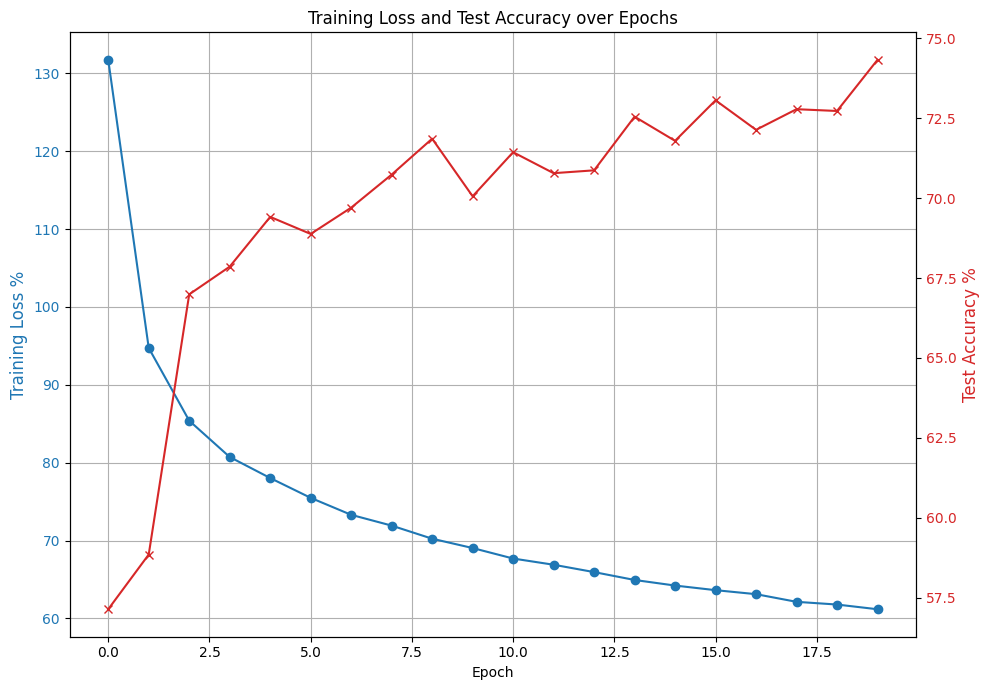

In [ ]:
# Plot loss and accuracy on the same figure using dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 7))

# Left y-axis for training loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss %', color=color, fontsize=12)
ax1.plot([loss * 100 for loss in train_loss], color=color, marker='o', label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Right y-axis for test accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Test Accuracy %', color=color, fontsize=12)
ax2.plot([acc * 100 for acc in test_acc], color=color, marker='x', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Training Loss and Test Accuracy over Epochs')
fig.tight_layout()
plt.show()


# Evaluate the Model

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1596
           1       0.75      0.58      0.65      1452
           2       0.71      0.71      0.71      1458
           3       0.83      0.76      0.80      1488
           4       0.69      0.77      0.73      1518
           5       0.75      0.69      0.72      1488

    accuracy                           0.74      9000
   macro avg       0.75      0.74      0.74      9000
weighted avg       0.75      0.74      0.74      9000



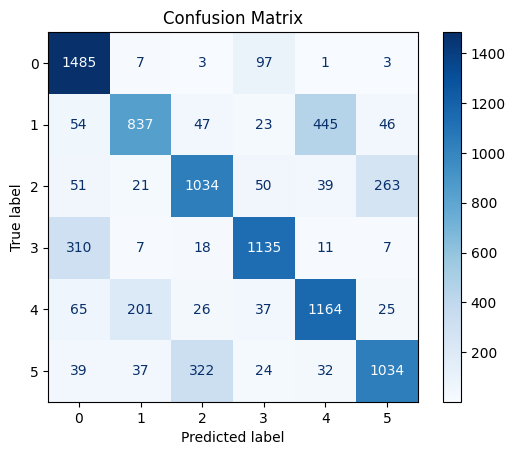

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu()
        y_true.extend(yb.numpy())
        y_pred.extend(preds.argmax(1).numpy())

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## Human Activity Dataset

In [1]:
print("run your own cell")

run your own cell


In [16]:
import zipfile
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [4]:


# Get the file path from the variable
file_path = "/content/human+activity+recognition+using+smartphones.zip"

# Define the directory to extract to
extract_dir = "/content/human_activity_data"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to: {extract_dir}")

uci_path = "/content/human_activity_data/UCI HAR Dataset.zip"
uci_exrtact_dir = "/content/uci_data"
os.makedirs(uci_exrtact_dir, exist_ok=True)
with zipfile.ZipFile(uci_path, 'r') as zip_ref:
    zip_ref.extractall(uci_exrtact_dir)

print(f"File extracted to: {uci_exrtact_dir}")

File extracted to: /content/human_activity_data
File extracted to: /content/uci_data


In [14]:
# Define paths to inertial signal files
train_dir = "/content/uci_data/UCI HAR Dataset/train/Inertial Signals"
test_dir = "/content/uci_data/UCI HAR Dataset/test/Inertial Signals"

# List of inertial signal files
signal_files = [
    "body_acc_x_{}.txt",
    "body_acc_y_{}.txt",
    "body_acc_z_{}.txt",
    "body_gyro_x_{}.txt",
    "body_gyro_y_{}.txt",
    "body_gyro_z_{}.txt",
    "total_acc_x_{}.txt",
    "total_acc_y_{}.txt",
    "total_acc_z_{}.txt"
]

# Function to load and merge inertial signals
def load_inertial_signals(data_dir, file_list, dataset_type="train"):
    signals = []
    for signal_file in file_list:
        file_path = os.path.join(data_dir, signal_file.format(dataset_type))
        # Load each signal file (each has shape (num_samples, 128))
        signal_data = np.loadtxt(file_path)
        signals.append(signal_data)

    # Stack signals along the last axis to get shape (num_samples, 128, num_signals)
    merged_data = np.stack(signals, axis=-1)
    return merged_data

# Load inertial signals for train and test sets
X_train = load_inertial_signals(train_dir, signal_files, "train")
X_test = load_inertial_signals(test_dir, signal_files, "test")

# Load labels
y_train = np.loadtxt("/content/uci_data/UCI HAR Dataset/train/y_train.txt")
y_test = np.loadtxt("/content/uci_data/UCI HAR Dataset/test/y_test.txt")

# Print shapes
print(f"X_train shape: {X_train.shape}, X_train type: {type(X_train)}")  # Expected: (7352, 128, 9)
print(f"y_train shape: {y_train.shape}, y_train type: {type(y_train)}")  # Expected: (7352,)
print(f"X_test shape: {X_test.shape}, X_test type: {type(X_test)}")    # Expected: (2947, 128, 9)
print(f"y_test shape: {y_test.shape}, y_test type: {type(y_test)}")    # Expected: (2947,)



X_train shape: (7352, 128, 9), X_train type: <class 'numpy.ndarray'>
y_train shape: (7352,), y_train type: <class 'numpy.ndarray'>
X_test shape: (2947, 128, 9), X_test type: <class 'numpy.ndarray'>
y_test shape: (2947,), y_test type: <class 'numpy.ndarray'>


In [17]:
# map real shape to expected shape ---  this is definitely not the best way to do this
# as seen above our datatyes are a numpy array
# convert to a 1-D tensor
X_train_tensor = torch.from_numpy(X_train).long()
X_test_tensor = torch.from_numpy(X_test).long()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

In [21]:
# check data types and shapes


print(X_train_tensor.dtype, X_train_tensor.shape)
print(X_test_tensor.dtype, X_test_tensor.shape)
print(y_train_tensor.dtype, y_train_tensor.shape)
print(y_test_tensor.dtype, y_test_tensor.shape)

torch.int64 torch.Size([7352, 128, 9])
torch.int64 torch.Size([2947, 128, 9])
torch.int64 torch.Size([7352])
torch.int64 torch.Size([2947])


In [25]:
# Convert and flatten to 1-D tensors
X_train_tensor = torch.from_numpy(X_train).view(-1).long()
X_test_tensor = torch.from_numpy(X_test).view(-1).long()
y_train_tensor = torch.from_numpy(y_train).view(-1).long()
y_test_tensor = torch.from_numpy(y_test).view(-1).long()

# Check data types and shapes
print(X_train_tensor.dtype, X_train_tensor.shape)
print(X_test_tensor.dtype, X_test_tensor.shape)
print(y_train_tensor.dtype, y_train_tensor.shape)
print(y_test_tensor.dtype, y_test_tensor.shape)


torch.int64 torch.Size([8469504])
torch.int64 torch.Size([3394944])
torch.int64 torch.Size([7352])
torch.int64 torch.Size([2947])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HAR1DCNN(nn.Module):
    def __init__(self, num_classes=6):  # HAR dataset has 6 activity classes
        super(HAR1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # [batch, 32, seq_len-2]
        x = F.relu(self.bn2(self.conv2(x)))   # [batch, 64, seq_len-4]
        x = self.pool(x).squeeze(-1)          # [batch, 64]
        x = self.fc(x)                        # [batch, num_classes]
        return x

In [ ]:
# # Instantiate model
# model = HAR1DCNN(num_classes=6).to(device) # Move the model to the device
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# #Training loop
# for epoch in range(10):
#     model.train()
#     for X_batch, y_batch in train_loader:
#         # X_batch is already in the shape [batch, channels=9, time=128] from the DataLoader
#         # X_batch = X_batch.permute(0, 2, 1)  # Remove this line
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         y_pred = model(X_batch)
#         loss = loss_fn(y_pred, y_batch)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Original X_train shape: (7352, 128, 9), type: <class 'numpy.ndarray'>
Original y_train shape: (7352,), type: <class 'numpy.ndarray'>
Original X_test shape: (2947, 128, 9), type: <class 'numpy.ndarray'>
Original y_test shape: (2947,), type: <class 'numpy.ndarray'>
Processed X_train shape: torch.Size([7352, 9, 128]), type: torch.float32
Processed y_train shape: torch.Size([7352]), type: torch.int64
Processed X_test shape: torch.Size([2947, 9, 128]), type: torch.float32
Processed y_test shape: torch.Size([2947]), type: torch.int64
Epoch 1/20 - Train Loss: 0.6088, Train Acc: 85.02%, Val Loss: 0.3829, Val Acc: 89.24%
Epoch 2/20 - Train Loss: 0.2339, Train Acc: 93.01%, Val Loss: 0.2861, Val Acc: 91.21%
Epoch 3/20 - Train Loss: 0.1756, Train Acc: 94.07%, Val Loss: 0.2498, Val Acc: 90.53%
Epoch 4/20 - Train Loss: 0.1515, Train Acc: 94.61%, Val Loss: 0.2478, Val Acc: 91.62%
Epoch 5/20 - Train Loss: 0.1399, Train Acc: 94.52%, Val Loss: 0.2363, Val Acc: 91.75%
Epoch 6/20 - Train Loss: 0.1340, Tra

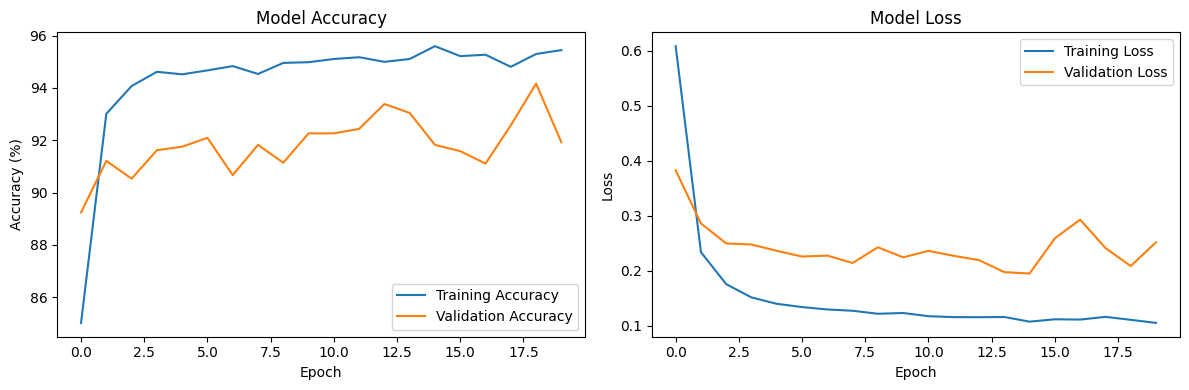

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# with shapes: X_train (7352, 128, 9), X_test (2947, 128, 9), y_train (7352,), y_test (2947,)

# Print original shapes
print(f"Original X_train shape: {X_train.shape}, type: {type(X_train)}")
print(f"Original y_train shape: {y_train.shape}, type: {type(y_train)}")
print(f"Original X_test shape: {X_test.shape}, type: {type(X_test)}")
print(f"Original y_test shape: {y_test.shape}, type: {type(y_test)}")

# Convert to PyTorch tensors and permute to (num_samples, channels=9, seq_len=128)
X_train_torch = torch.from_numpy(X_train).float().permute(0, 2, 1)  # Shape: (7352, 9, 128)
X_test_torch = torch.from_numpy(X_test).float().permute(0, 2, 1)    # Shape: (2947, 9, 128)

# Adjust labels to be zero-indexed (0 to 5 instead of 1 to 6)
y_train_adj = y_train - 1
y_test_adj = y_test - 1
y_train_torch = torch.from_numpy(y_train_adj).long()  # Shape: (7352,)
y_test_torch = torch.from_numpy(y_test_adj).long()    # Shape: (2947,)

# Print processed shapes
print(f"Processed X_train shape: {X_train_torch.shape}, type: {X_train_torch.dtype}")
print(f"Processed y_train shape: {y_train_torch.shape}, type: {y_train_torch.dtype}")
print(f"Processed X_test shape: {X_test_torch.shape}, type: {X_test_torch.dtype}")
print(f"Processed y_test shape: {y_test_torch.shape}, type: {y_test_torch.dtype}")

# Create DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the HAR1DCNN model
class HAR1DCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(HAR1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # [batch, 32, seq_len-2]
        x = F.relu(self.bn2(self.conv2(x)))   # [batch, 64, seq_len-4]
        x = self.pool(x).squeeze(-1)          # [batch, 64]
        x = self.fc(x)                        # [batch, num_classes]
        return x

# Initialize model, loss function, and optimizer
model = HAR1DCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_loss / len(test_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

# Evaluate on test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print classification report
activity_labels = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=activity_labels))

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Confusion Matrix:
[[495   0   1   0   0   0]
 [  1 460  10   0   0   0]
 [  4   7 408   0   1   0]
 [  0  25   0 377  89   0]
 [  0   1   0  72 459   0]
 [  0  27   0   0   0 510]]


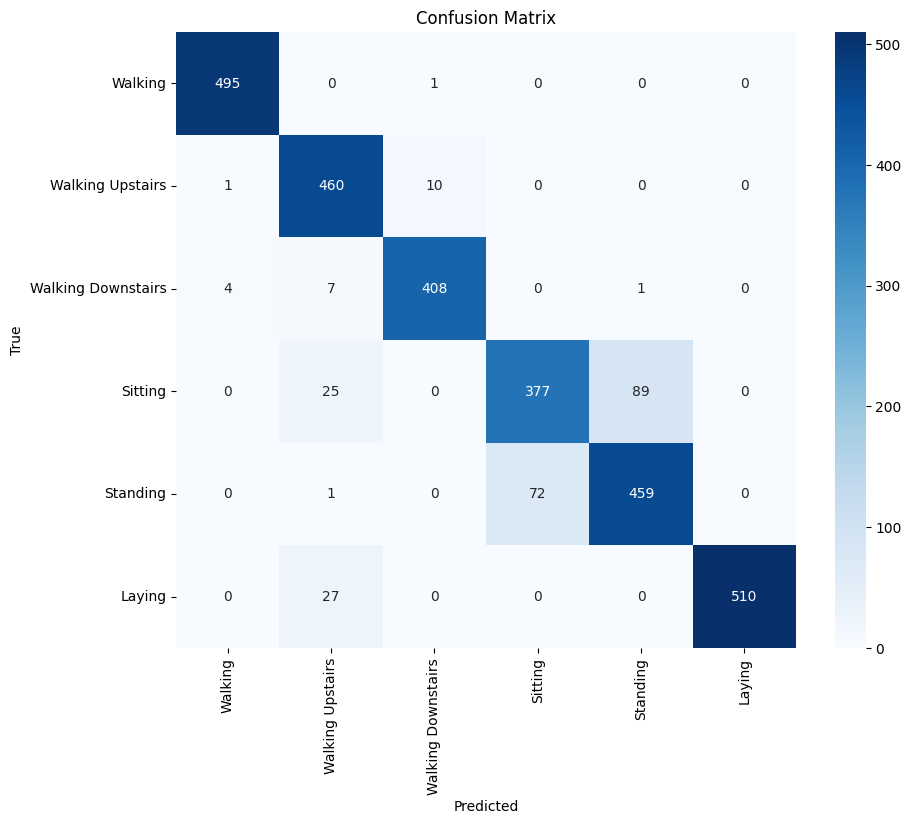

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true and y_pred are lists or NumPy arrays with shape (2947,) containing labels 0–5

# Define activity labels
activity_labels = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()